# 07/05/2017 Update

This project is based on my [GitHub link][1] and my research is based on  [this paper][2]. 

Instead of using Echo state network which was used in the Stanford research paper, we are going to use LSTM which is more advanced in training the neural network.

More updates will be provided to accommodate the dataset in this Kaggle challenge.  You can simply adjust it to choose your features and window for data.

Thank you all!

# Import module first


  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data
  [2]: http://cs229.stanford.edu/proj2012/BernalFokPidaparthi-FinancialMarketTimeSeriesPredictionwithRecurrentNeural.pdf

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

from scipy.optimize import curve_fit

# Read data and transform them to pandas dataframe

In [2]:
WINDOW_SIZE = 10

### Load Data

In [66]:
df_pm1 = pd.read_csv("data/pm1_output_Taft Ave._2015.csv", index_col = 0)
df_pm1 = df_pm1.drop(['Actual'], axis=1)

df_pm2 = pd.read_csv("data/pm2_output_Taft Ave._2015.csv", index_col = 0)
df_pm2 = df_pm2.drop(['Actual'], axis=1)

# Converting the index as date
df_pm1.index = pd.to_datetime(df_pm1.index)
df_pm2.index = pd.to_datetime(df_pm2.index)

In [99]:
df_pm1_indent = pd.DataFrame(df_pm1)
print('Before = ' + str(len(df_pm1_indent)))

NEXT_INDEX = pd.date_range(df_pm1_indent.index[-1], periods=WINDOW_SIZE + 1, freq='15Min') + pd.Timedelta(minutes=15)

for i in NEXT_INDEX:
    df_pm1_indent.loc[i] = np.nan
print('After = ' + str(len(df_pm1_indent)))

df_pm1_indent = df_pm1_indent.shift(WINDOW_SIZE + 1)

# Extrapolate values
df_pm1_indent.interpolate(method='nearest', axis=0).ffill().bfill()

# Function to curve fit to the data
def func(x, a, b, c, d):
    return a * (x ** 3) + b * (x ** 2) + c * x + d

# Initial parameter guess, just to kick off the optimization
guess = (0.5, 0.5, 0.5, 0.5)

# Temporarily remove dates and make index numeric
di = df_pm1_indent.index
df_pm1_indent = df_pm1_indent.reset_index().drop('dt', 1)

# Create copy of data to remove NaNs for curve fitting
fit_df = df_pm1_indent.dropna()

# Place to store function parameters for each column
col_params = {}

# Curve fit each column
for col in fit_df.columns:
    # Get x & y
    x = fit_df.index.astype(float).values
    y = fit_df[col].values
    # Curve fit column and get curve parameters
    params = curve_fit(func, x, y, guess)
    # Store optimized parameters
    col_params[col] = params[0]

# Extrapolate each column
for col in df_pm1_indent.columns:
    # Get the index values for NaNs in the column
    x = df_pm1_indent[pd.isnull(df[col])].index.astype(float).values
    # Extrapolate those points with the fitted function
    df_pm1_indent[col][x] = func(x, *col_params[col])

# Put date index back
df_pm1_indent.index = di

df_pm1_indent.head()

Before = 23477
After = 23488


,Predicted
dt,
2015-05-04 19:15:00,0.345503
2015-05-04 19:30:00,0.345487
2015-05-04 19:45:00,0.345471
2015-05-04 20:00:00,0.345455
2015-05-04 20:15:00,0.345439


In [109]:
# Move label to be predicted at the end
# Y_COL_NAME = ['statusS']
# df_final = df[[c for c in df if c not in Y_COL_NAME] + [c for c in Y_COL_NAME if c in df]]
# df_final.tail()

df_final = df_pm2.copy()
df_final.columns = ['pm2']

df_final['pm1'] = df_pm1_indent[0:-(WINDOW_SIZE + 1)]
df_final.head()

# df_pm1_indent[0:-(WINDOW_SIZE + 1)]

,pm2,pm1
dt,,
2015-05-04 19:15:00,0.220617,0.345503
2015-05-04 19:30:00,0.214830,0.345487
2015-05-04 19:45:00,0.209188,0.345471
2015-05-04 20:00:00,0.203692,0.345455
2015-05-04 20:15:00,0.198230,0.345439


# Create training set and testing set

In [110]:
def load_data(stock, seq_len, split_percent):

    amount_of_features = len(stock.columns) - 1
 
    data = stock.as_matrix() 

    sequence_length = seq_len + 1 # index starting from 0
    
    x_data = []
    y_data = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        x_data.append(data[index: index + sequence_length, 0:amount_of_features]) # index : index + 22days
        y_data.append(data[index: index + sequence_length, -1]) # index : index + 22days

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    row = round(split_percent * x_data.shape[0]) # 90% split
    
    x_train = x_data[:int(row), :-1]
    
    y_train = y_data[:int(row), -1]
    
    x_test = x_data[int(row):, :-1]
    
    y_test = y_data[int(row):, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Build the structure of model

Based on my hyperparameter testing on [here][1]. I found that these parameters are the most suitable for this task.

![dropout = 0.3][2]
![epochs = 90][3]
![LSTM 256 > LSTM 256 > Relu 32 > Linear 1][4]



  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data
  [2]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/dropout.png?raw=true
  [3]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/epochs2.png?raw=true
  [4]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/neurons.png?raw=true

In [111]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# Train the model

In [112]:
PERCENT_SPLIT = 0.9
X_train, y_train, X_test, y_test = load_data(df_final, WINDOW_SIZE, PERCENT_SPLIT)

In [113]:
model = build_model([len(df_final.columns) - 1,WINDOW_SIZE ,1])

Compilation Time :  0.027058839797973633


In [114]:
model.fit(X_train,y_train,batch_size=512,epochs=10,validation_split=0.1,verbose=1)

Train on 19007 samples, validate on 2112 samples
Epoch 1/10
19007/19007 [==============================] - 42s 2ms/step - loss: 0.0611 - acc: 0.0000e+00 - val_loss: 0.0666 - val_acc: 0.0000e+00
Epoch 2/10
19007/19007 [==============================] - 2s 118us/step - loss: 0.0319 - acc: 0.0000e+00 - val_loss: 0.0661 - val_acc: 0.0000e+00
Epoch 3/10
19007/19007 [==============================] - 3s 143us/step - loss: 0.0309 - acc: 0.0000e+00 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 4/10
19007/19007 [==============================] - 2s 113us/step - loss: 0.0307 - acc: 0.0000e+00 - val_loss: 0.0700 - val_acc: 0.0000e+00
Epoch 5/10
19007/19007 [==============================] - 2s 113us/step - loss: 0.0306 - acc: 0.0000e+00 - val_loss: 0.0692 - val_acc: 0.0000e+00
Epoch 6/10
19007/19007 [==============================] - 2s 114us/step - loss: 0.0308 - acc: 0.0000e+00 - val_loss: 0.0697 - val_acc: 0.0000e+00
Epoch 7/10
19007/19007 [==============================] - 2s 115us/step - lo

# Evaluate model

In [115]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.03398 MSE (0.18 RMSE)
Test Score: 0.02315 MSE (0.15 RMSE)


(0.03397798148087966, 0.02314968182894623)

# Visualize prediction

In [116]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(2347, 1)


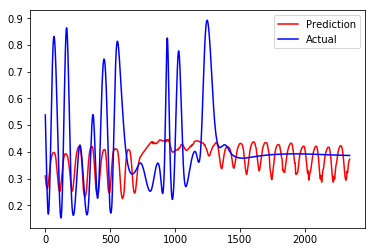

In [117]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='Prediction')
plt2.plot(y_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [118]:
X_train_final, y_train_final, X_test_final, y_test_final = load_data(df_final, WINDOW_SIZE, 1)
p_final = model.predict(X_train_final)

In [121]:
df_result = pd.DataFrame(df_final['pm1'])

p_final_interpolated = df_final['pm1'][0:WINDOW_SIZE + 1].values
p_final_interpolated = np.append(p_final_interpolated, p_final.reshape(1, -1)[0])
df_result.columns = ['Actual']
df_result['Predicted'] = p_final_interpolated.reshape(-1, 1)

df_result.to_csv('data/lstm_output_Taft Ave._2015.csv')